In [ ]:
!pip install statsmodels


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# from causalinference import CausalModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import AutoReg

In [ ]:
# Get the current working directory of the script
cwd = os.getcwd()

# Define the relative path to the data file
# data_path = os.path.join(cwd, '..', 'data', 'my_data.csv')


# Read the data file using pandas
covid_data = pd.read_csv('/content/covid_19_india.csv')
# start date: 30-01-2020 end date:11-08-2021
# print(covid_data, data_path)

vaccine_state_data = pd.read_csv('/content/covid_vaccine_statewise.csv')

state_test_data = pd.read_csv('/content/StatewiseTestingDetails.csv')

In [ ]:
import pandas as pd

# Convert date columns to datetime format
covid_data['Date'] = pd.to_datetime(covid_data['Date'], format='%d-%m-%Y')
vaccine_state_data['Updated On'] = pd.to_datetime(vaccine_state_data['Updated On'], format='%d-%m-%Y')
state_test_data['Date'] = pd.to_datetime(state_test_data['Date'], format='%d-%m-%Y')

# Convert relevant covid_data columns to numeric
covid_data[['Cured', 'Deaths', 'Confirmed']] = covid_data[['Cured', 'Deaths', 'Confirmed']].apply(pd.to_numeric, errors='coerce')

# Convert state_test_data columns to numeric
state_test_data[['TotalSamples', 'Negative', 'Positive']] = state_test_data[['TotalSamples', 'Negative', 'Positive']].apply(pd.to_numeric, errors='coerce')

# Strip any whitespace in column names just in case
vaccine_state_data.columns = vaccine_state_data.columns.str.strip()

# Convert vaccination data columns to numeric
numeric_cols = [
    'Total Doses Administered', 'Sessions', 'Sites', 'First Dose Administered',
    'Second Dose Administered', 'Male (Doses Administered)', 'Female (Doses Administered)',
    'Transgender (Doses Administered)', 'Covaxin (Doses Administered)',
    'CoviShield (Doses Administered)', 'Sputnik V (Doses Administered)', 'AEFI',
    '18-44 Years (Doses Administered)', '45-60 Years (Doses Administered)',
    '60+ Years (Doses Administered)', 'Total Individuals Vaccinated'
]

# Fix column names with whitespace issues
vaccine_state_data.rename(columns={
    ' Sites ': 'Sites',
    ' Covaxin (Doses Administered)': 'Covaxin (Doses Administered)'
}, inplace=True)

vaccine_state_data[numeric_cols] = vaccine_state_data[numeric_cols].apply(pd.to_numeric, errors='coerce')


In [ ]:
print("Covid 19 Data")
print(covid_data.head())
print("\n\nVaccine for State wise data")
print(vaccine_state_data.head())
print("\n\nState Testing Data")
print(state_test_data.head())

Covid 19 Data
   Sno       Date     Time State/UnionTerritory ConfirmedIndianNational  \
0    1 2020-01-30  6:00 PM               Kerala                       1   
1    2 2020-01-31  6:00 PM               Kerala                       1   
2    3 2020-02-01  6:00 PM               Kerala                       2   
3    4 2020-02-02  6:00 PM               Kerala                       3   
4    5 2020-02-03  6:00 PM               Kerala                       3   

  ConfirmedForeignNational  Cured  Deaths  Confirmed  
0                        0      0       0          1  
1                        0      0       0          1  
2                        0      0       0          2  
3                        0      0       0          3  
4                        0      0       0          3  


Vaccine for State wise data
  Updated On  State  Total Doses Administered  Sessions    Sites  \
0 2021-01-16  India                   48276.0    3455.0   2957.0   
1 2021-01-17  India                   5

In [ ]:
print(covid_data['State/UnionTerritory'].unique())
print(vaccine_state_data['State'].unique())
print(state_test_data['State'].unique())
print((covid_data['State/UnionTerritory'].unique().shape))
print((vaccine_state_data['State'].unique().shape))
print((state_test_data['State'].unique().shape))

['Kerala' 'Telangana' 'Delhi' 'Rajasthan' 'Uttar Pradesh' 'Haryana'
 'Ladakh' 'Tamil Nadu' 'Karnataka' 'Maharashtra' 'Punjab'
 'Jammu and Kashmir' 'Andhra Pradesh' 'Uttarakhand' 'Odisha' 'Puducherry'
 'West Bengal' 'Chhattisgarh' 'Chandigarh' 'Gujarat' 'Himachal Pradesh'
 'Madhya Pradesh' 'Bihar' 'Manipur' 'Mizoram'
 'Andaman and Nicobar Islands' 'Goa' 'Unassigned' 'Assam' 'Jharkhand'
 'Arunachal Pradesh' 'Tripura' 'Nagaland' 'Meghalaya'
 'Dadra and Nagar Haveli and Daman and Diu'
 'Cases being reassigned to states' 'Sikkim' 'Daman & Diu' 'Lakshadweep'
 'Dadra and Nagar Haveli']
['India' 'Andaman and Nicobar Islands' 'Andhra Pradesh'
 'Arunachal Pradesh' 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh'
 'Dadra and Nagar Haveli and Daman and Diu' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Ladakh' 'Lakshadweep' 'Madhya Pradesh' 'Maharashtra' 'Manipur'
 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab'
 'Rajasthan'

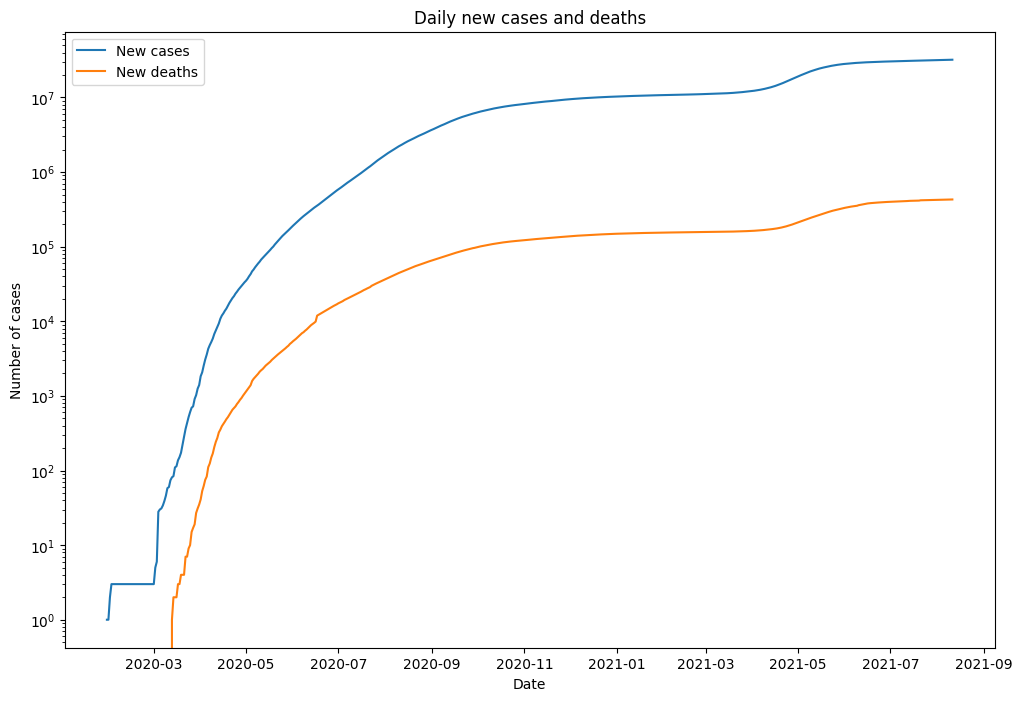

In [ ]:
# Convert date column to datetime format
# covid_data['Date'] = pd.to_datetime(covid_data['Date'])

# Group by date and sum new cases and deaths
daily_data = covid_data.copy().groupby('Date')[['Confirmed', 'Deaths']].sum()

# Plot daily new cases and deaths
fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(daily_data.index, np.log(daily_data['Confirmed']), label='New cases')
# ax.plot(daily_data.index, np.log(daily_data['Deaths']+1), label='New deaths')
ax.plot(daily_data.index, daily_data['Confirmed'], label='New cases')
ax.plot(daily_data.index, daily_data['Deaths'], label='New deaths')

ax.set_xlabel('Date')
ax.set_ylabel('Number of cases')
ax.set_title('Daily new cases and deaths')
ax.set_yscale('log')
ax.legend()
plt.show()

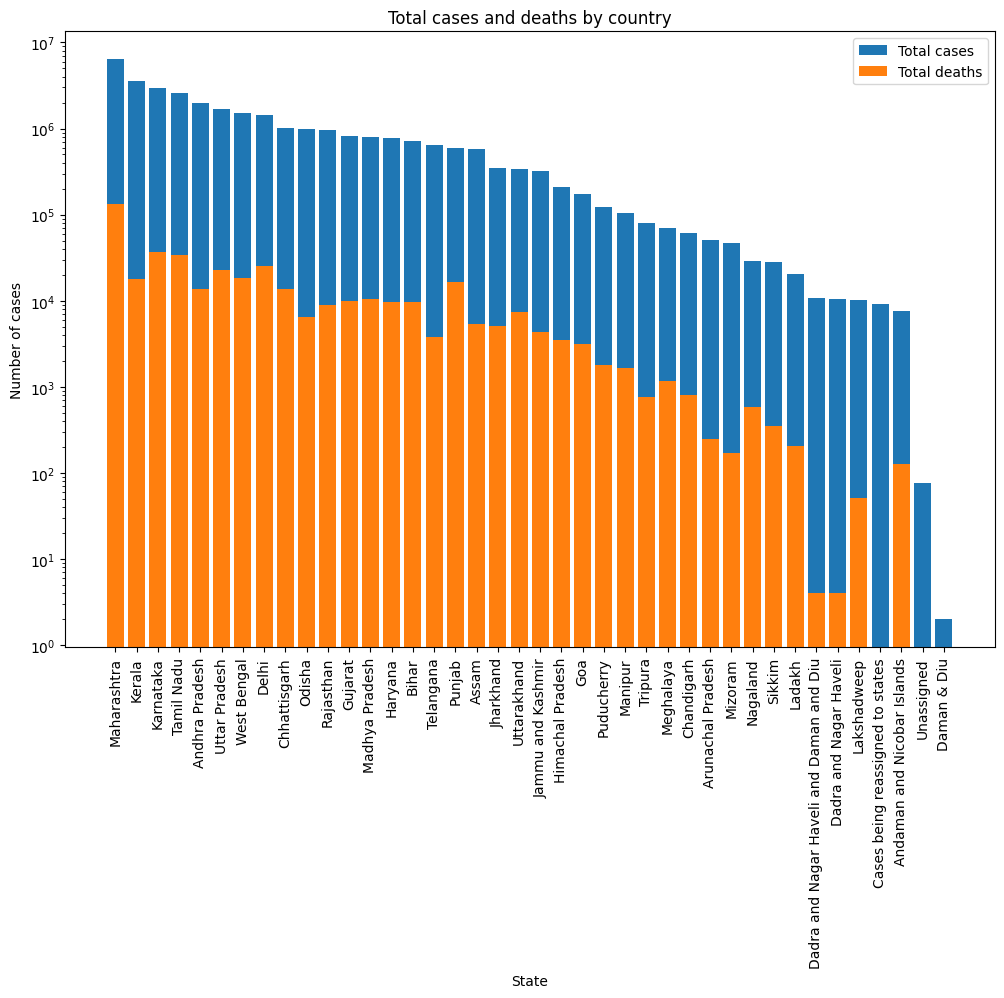

In [ ]:
# Group by country and sum total cases and deaths
country_data = covid_data.copy().groupby('State/UnionTerritory')[['Confirmed', 'Deaths']].max()

# Sort by total cases
country_data = country_data.sort_values('Confirmed', ascending=False)

# Plot total cases and deaths by country
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(country_data.index, country_data['Confirmed'], label='Total cases')
ax.bar(country_data.index, country_data['Deaths'], label='Total deaths')
ax.set_xlabel('State')
ax.set_ylabel('Number of cases')
ax.set_title('Total cases and deaths by country')
ax.set_yscale('log')
ax.legend()
plt.xticks(rotation=90)
plt.show()

RMSE: 30365.030360179502
MAE: 23113.359210774037


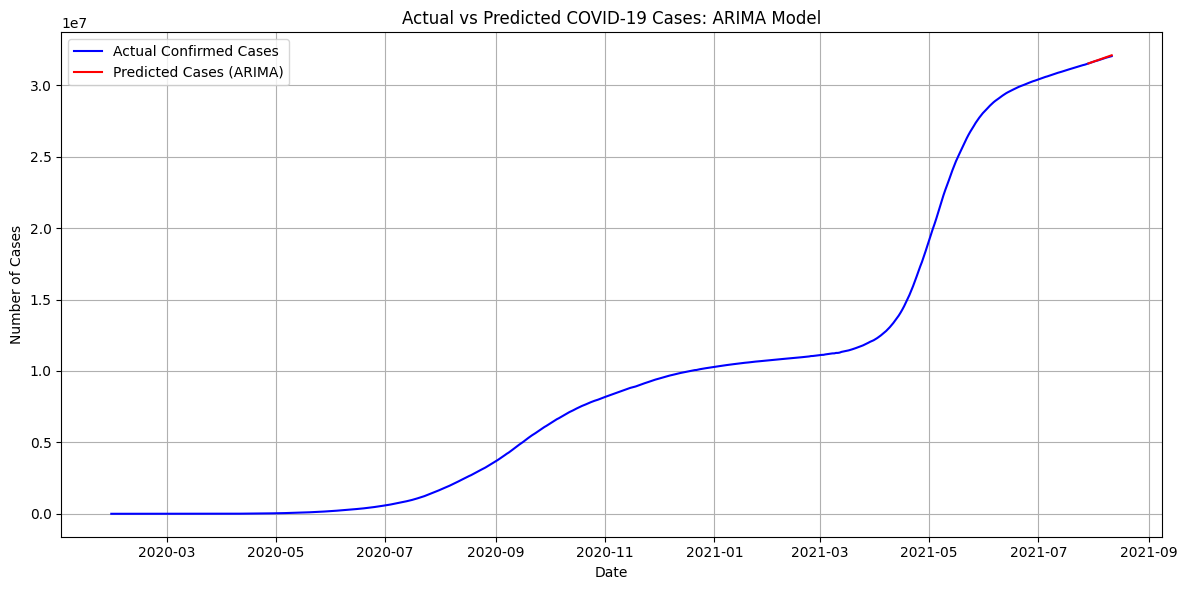

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set parameters
noOfDaysFromLast = 14
overallLags = 7

# Copy and preprocess data
data = covid_data.copy()
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format
data = data.set_index('Date')  # Set index to 'Date'
data = data.resample('D').sum()  # Resample to daily frequency

# Optional: Take difference to make series stationary
# data['Confirmed'] = data['Confirmed'].diff().dropna()

# Split data into training and testing sets
train_data = data[:-noOfDaysFromLast]
test_data = data[-noOfDaysFromLast:]

# Build and fit the ARIMA model
model = ARIMA(
    endog=train_data['Confirmed'],
    exog=train_data[['Deaths', 'Cured']],
    order=(overallLags, 1, 1)
)
model_fit = model.fit()

# Make predictions on test set
predictions = model_fit.forecast(
    steps=len(test_data),
    exog=test_data[['Deaths', 'Cured']]
)

# Evaluate model performance
mse = mean_squared_error(test_data['Confirmed'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Confirmed'], predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Confirmed'], label='Actual Confirmed Cases', color='blue')
plt.plot(test_data.index, predictions, label='Predicted Cases (ARIMA)', color='red')
plt.title('Actual vs Predicted COVID-19 Cases: ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 47898.20167850287
MAE: 36810.347917965744


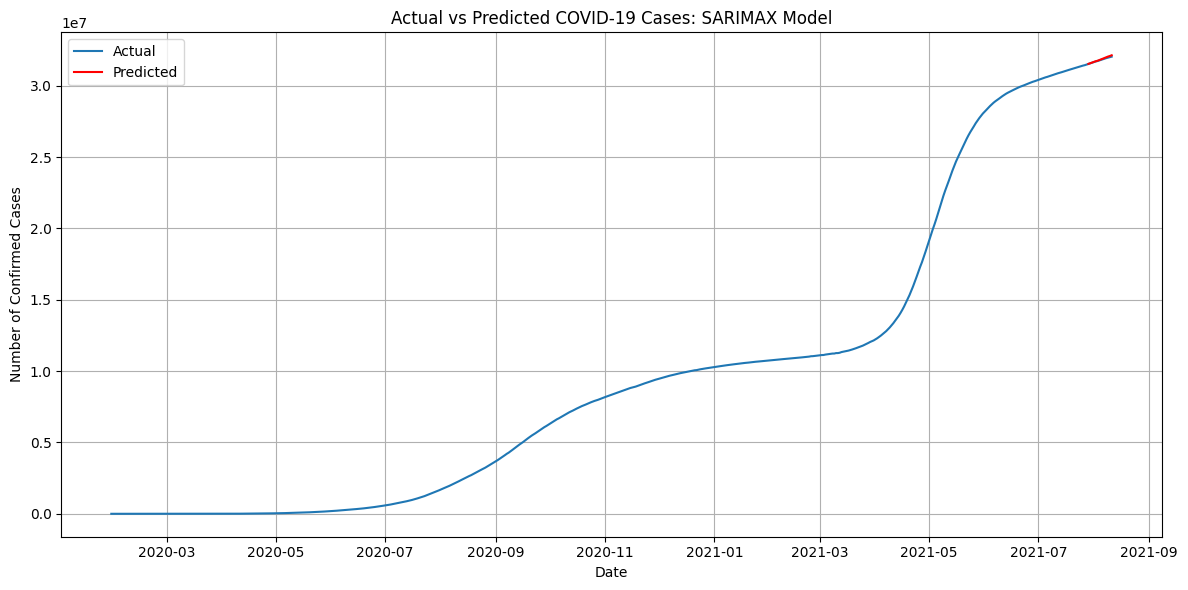

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- CONFIGURATION ---
noOfDaysFromLast = 14       # Number of days for test set
overallLags = 5             # AR lag for the SARIMAX model
seasonal_order = (5, 1, 1, 7)  # Weekly seasonality

# --- DATA LOADING & PREPROCESSING ---
# Assuming covid_data is already loaded and contains columns: ['Date', 'Sno', 'Confirmed', 'Deaths', 'Cured', ...]
data = covid_data.copy()

# Set 'Date' as datetime index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Drop unnecessary columns
if 'Sno' in data.columns:
    data = data.drop('Sno', axis=1)

# Resample to daily frequency and aggregate
data = data.resample('D').sum()

# Split into train and test sets
train_data = data.iloc[:-noOfDaysFromLast]
test_data = data.iloc[-noOfDaysFromLast:]

# --- MODEL TRAINING ---
model = SARIMAX(
    endog=train_data['Confirmed'],
    exog=train_data[['Deaths', 'Cured']],
    order=(overallLags, 1, 1),
    seasonal_order=seasonal_order
)
model_fit = model.fit(disp=False)

# --- PREDICTION ---
predictions = model_fit.forecast(steps=len(test_data), exog=test_data[['Deaths', 'Cured']])

# --- EVALUATION ---
mse = mean_squared_error(test_data['Confirmed'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Confirmed'], predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# --- VISUALIZATION ---
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Confirmed'], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted COVID-19 Cases: SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


RMSE: 38242.5433008433
MAE: 28300.31845706116


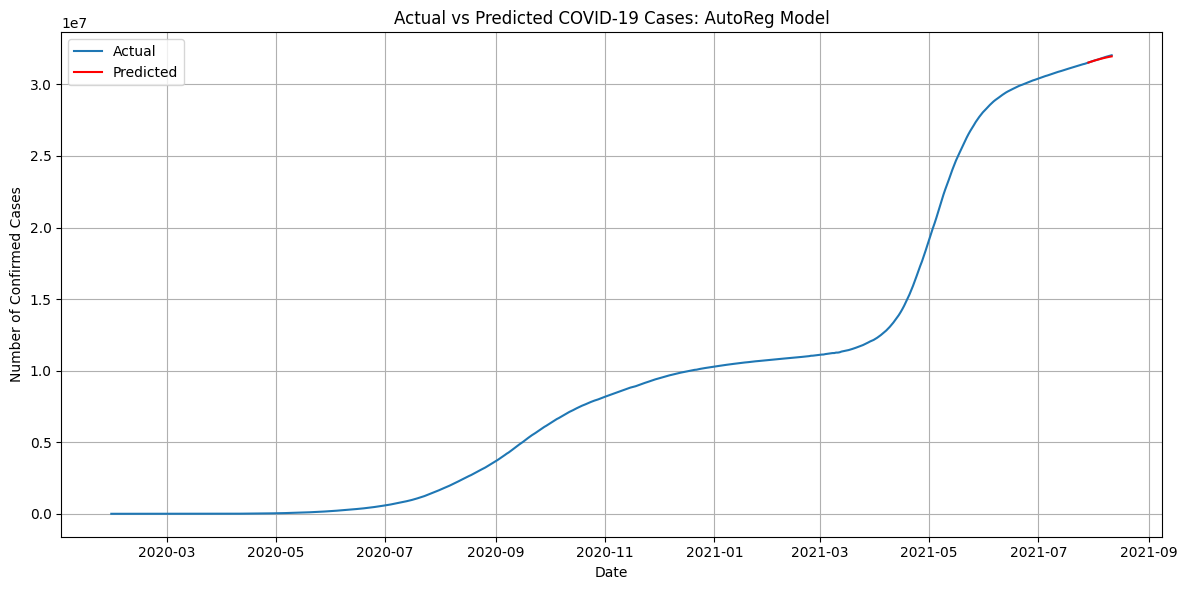

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- CONFIGURATION ---
noOfDaysFromLast = 14    # Number of days used for test set
overallLags = 7            # Number of lags in AutoReg model
column_selected = 'Confirmed'  # Column to forecast

# --- DATA PREPARATION ---
# Assuming covid_data is already loaded and includes columns like: ['Date', 'Sno', 'Confirmed', 'Deaths', 'Cured', ...]

data = covid_data.copy()

# Ensure 'Date' is datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as index
data = data.set_index('Date')

# Drop unnecessary columns and resample to daily frequency
if 'Sno' in data.columns:
    data = data.drop('Sno', axis=1)
data = data.resample('D').sum()

# --- TRAIN-TEST SPLIT ---
train_data = data[:-noOfDaysFromLast]
test_data = data[-noOfDaysFromLast:]

# --- MODEL TRAINING ---
model = AutoReg(endog=train_data[column_selected], lags=overallLags)
model_fit = model.fit()

# --- FORECASTING ---
predictions = model_fit.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

# --- EVALUATION ---
mse = mean_squared_error(test_data[column_selected], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data[column_selected], predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# --- VISUALIZATION ---
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[column_selected], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted COVID-19 Cases: AutoReg Model')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Root Mean Squared Error: 6472.987064397512
Mean Absolute Error: 5002.252077089889


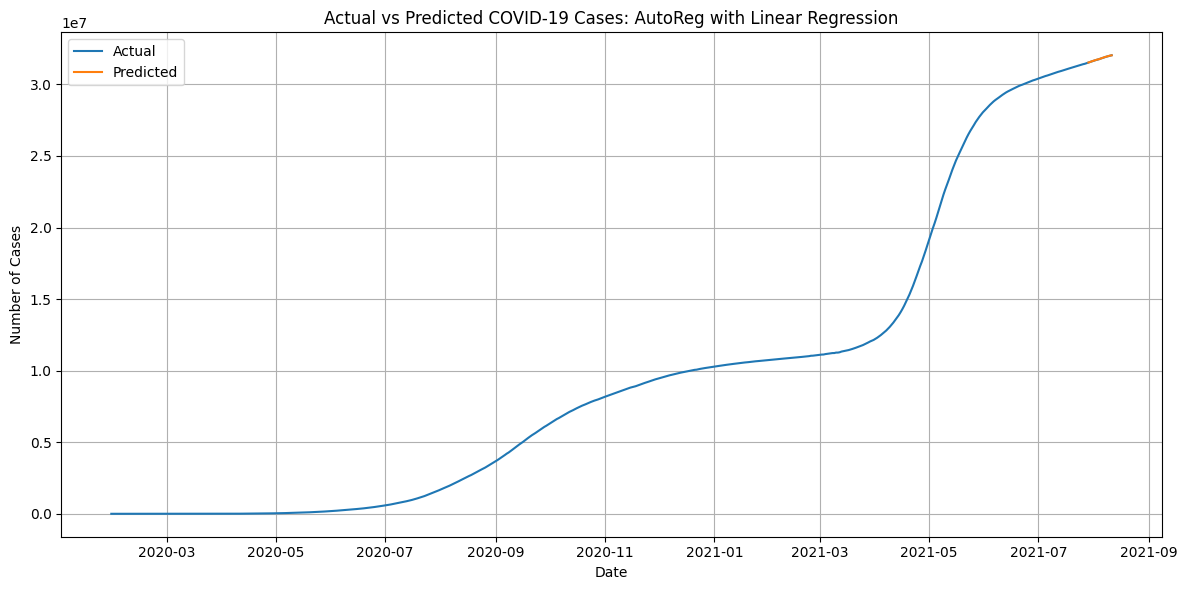

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Parameters
noOfDaysFromLast = 14
overallLags = 7
column_selected = 'Confirmed'

# Load and preprocess data
data = covid_data.copy()
# data['Date'] = pd.to_datetime(data['Date'])  # Uncomment if 'Date' isn't datetime already
data = data.set_index('Date')
data = data.resample('D').sum()  # Resample to daily data
data = data.drop('Sno', axis=1)

# Create lag features
for lag in range(1, overallLags + 1):
    data[f'{column_selected}_{lag}'] = data[column_selected].shift(lag)

# Split data into train and test
split = -noOfDaysFromLast
train_data = data.iloc[:split].dropna()
test_data = data.iloc[split:].dropna()

# Prepare features and targets
X_train = train_data.drop(columns=[column_selected])
X_train = X_train.select_dtypes(include=[np.number])  # Keep only numeric columns
y_train = train_data[column_selected]

X_test = test_data.drop(columns=[column_selected])
X_test = X_test[X_train.columns]  # Ensure same columns
y_test = test_data[column_selected]

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

# Evaluate model
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
mae = mean_absolute_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data[column_selected], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted COVID-19 Cases: AutoReg with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Selected states: ['Kerala' 'Telangana' 'Delhi' 'Rajasthan' 'Uttar Pradesh' 'Haryana'
 'Ladakh' 'Tamil Nadu' 'Karnataka' 'Maharashtra' 'Punjab'
 'Jammu and Kashmir' 'Andhra Pradesh' 'Uttarakhand' 'Odisha' 'Puducherry'
 'West Bengal' 'Chhattisgarh' 'Chandigarh' 'Gujarat' 'Himachal Pradesh'
 'Madhya Pradesh' 'Bihar' 'Manipur' 'Mizoram'
 'Andaman and Nicobar Islands' 'Goa' 'Unassigned' 'Assam' 'Jharkhand'
 'Arunachal Pradesh' 'Tripura' 'Nagaland' 'Meghalaya'
 'Dadra and Nagar Haveli and Daman and Diu'
 'Cases being reassigned to states' 'Sikkim' 'Daman & Diu' 'Lakshadweep'
 'Dadra and Nagar Haveli']


<ipython-input-14-8a40eba2b1f2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['Date'] = pd.to_datetime(df_state['Date'], format='%d-%m-%Y')


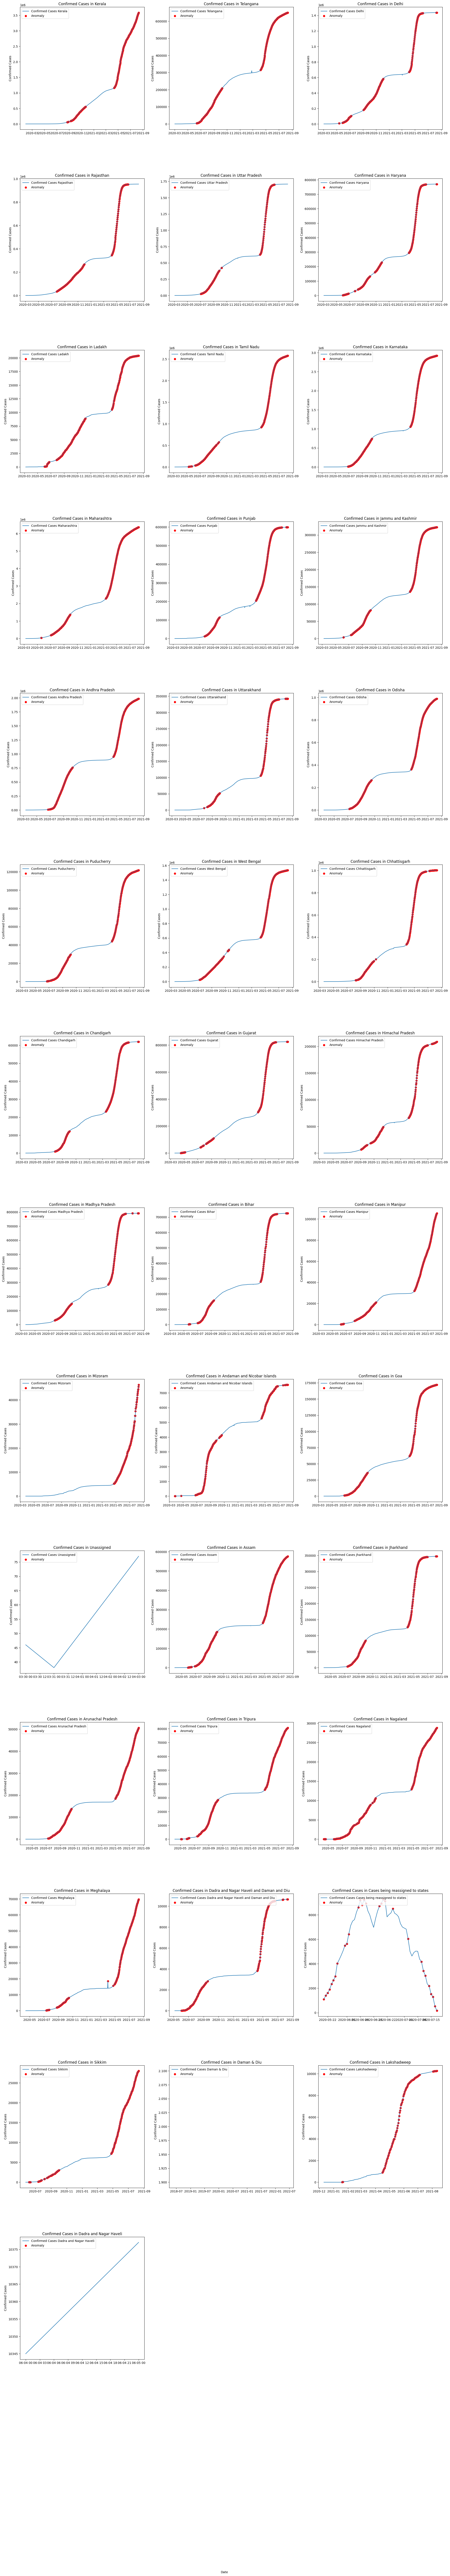

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest

# Load the covid data (replace this with your actual dataframe)
df = covid_data.copy()

# Get all unique states
allstates = df['State/UnionTerritory'].unique()
print(f"Selected states: {allstates}")

# Set up the grid for subplots
cols_req = 3  # Adjust this to control the number of columns in grid
# Adjust the number of rows based on the total number of states
rows_req = len(allstates) // cols_req + 1  # Add extra row if not perfectly divisible

fig, axs = plt.subplots(rows_req, cols_req, figsize=(25, 10 * rows_req), sharex=False, gridspec_kw={'hspace': 0.4})

# Flatten the axes array for easy indexing
axs = axs.flatten()

# Loop through the states and plot time series for each
for i, state in enumerate(allstates):
    # Subset the dataframe for the selected state and the Confirmed column
    df_state = df.loc[df['State/UnionTerritory'] == state, ['Date', 'Confirmed']]

    # Convert the Date column to datetime
    df_state['Date'] = pd.to_datetime(df_state['Date'], format='%d-%m-%Y')

    # Set the Date column as the dataframe index
    df_state.set_index('Date', inplace=True)

    # Handle missing or malformed data by dropping rows with missing Confirmed values
    df_state = df_state.dropna(subset=['Confirmed'])

    # Plot the time series of confirmed cases for the state
    axs[i].plot(df_state.index, df_state['Confirmed'], label=f'Confirmed Cases {state}')

    # Initialize IsolationForest model for anomaly detection
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42)
    model.fit(df_state[['Confirmed']])  # Fit model on the confirmed cases

    # Add a column to the dataframe indicating anomalies (1 for normal, -1 for anomaly)
    df_state['Anomaly'] = model.predict(df_state[['Confirmed']])
    df_state['Anomaly'] = df_state['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

    # Plot anomalies with red dots on the time series
    axs[i].scatter(df_state.loc[df_state['Anomaly'] == 'Anomaly'].index,
                    df_state.loc[df_state['Anomaly'] == 'Anomaly']['Confirmed'],
                    color='red', label='Anomaly')

    # Set the title and labels for each subplot
    axs[i].set_title(f'Confirmed Cases in {state}')
    axs[i].set_ylabel('Confirmed Cases')
    axs[i].legend(loc='upper left')

# Add a common x-label for the entire figure
fig.text(0.5, 0.04, 'Date', ha='center')

# Remove any unused subplots (in case the number of states doesn't perfectly fill the grid)
for i in range(len(allstates), len(axs)):
    fig.delaxes(axs[i])

# Show the plot
plt.show()


<ipython-input-35-5e4eb057305a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_period['Confirmed_zscore'] = (df_period['Confirmed'] - df_period['Confirmed'].mean()) / df_period['Confirmed'].std()
<ipython-input-35-5e4eb057305a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_period['Deaths_zscore'] = (df_period['Deaths'] - df_period['Deaths'].mean()) / df_period['Deaths'].std()


Outliers in Confirmed cases:
              Sno     Time State/UnionTerritory ConfirmedIndianNational  \
Date                                                                      
2021-03-13  12659  8:00 AM          Maharashtra                       -   
2021-03-14  12695  8:00 AM          Maharashtra                       -   
2021-03-15  12731  8:00 AM          Maharashtra                       -   
2021-03-16  12767  8:00 AM          Maharashtra                       -   
2021-03-17  12803  8:00 AM          Maharashtra                       -   
...           ...      ...                  ...                     ...   
2021-08-10  18069  8:00 AM           Tamil Nadu                       -   
2021-08-11  18090  8:00 AM            Karnataka                       -   
2021-08-11  18091  8:00 AM               Kerala                       -   
2021-08-11  18095  8:00 AM          Maharashtra                       -   
2021-08-11  18105  8:00 AM           Tamil Nadu                       -

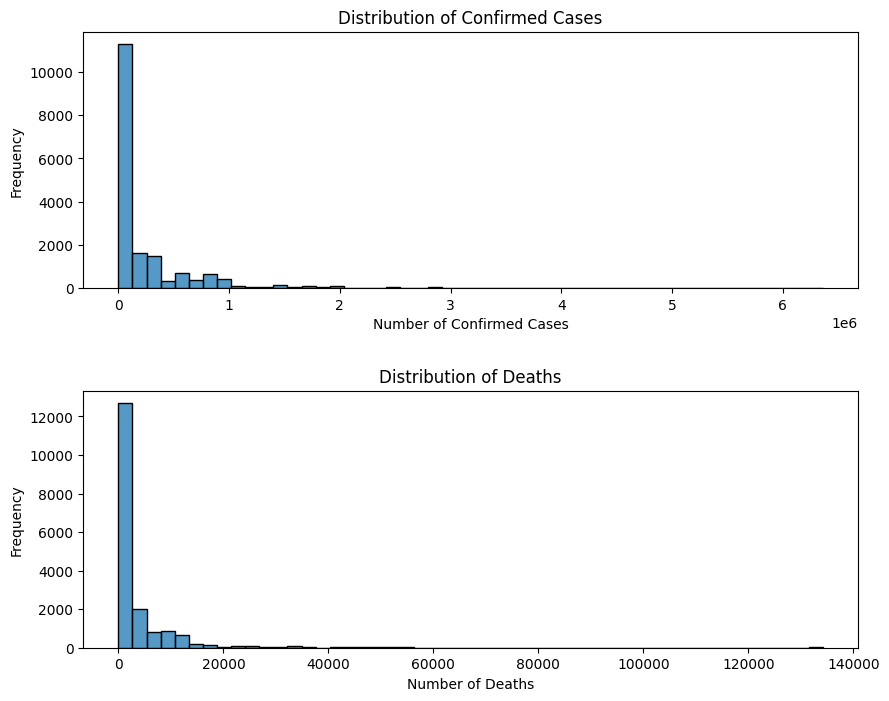

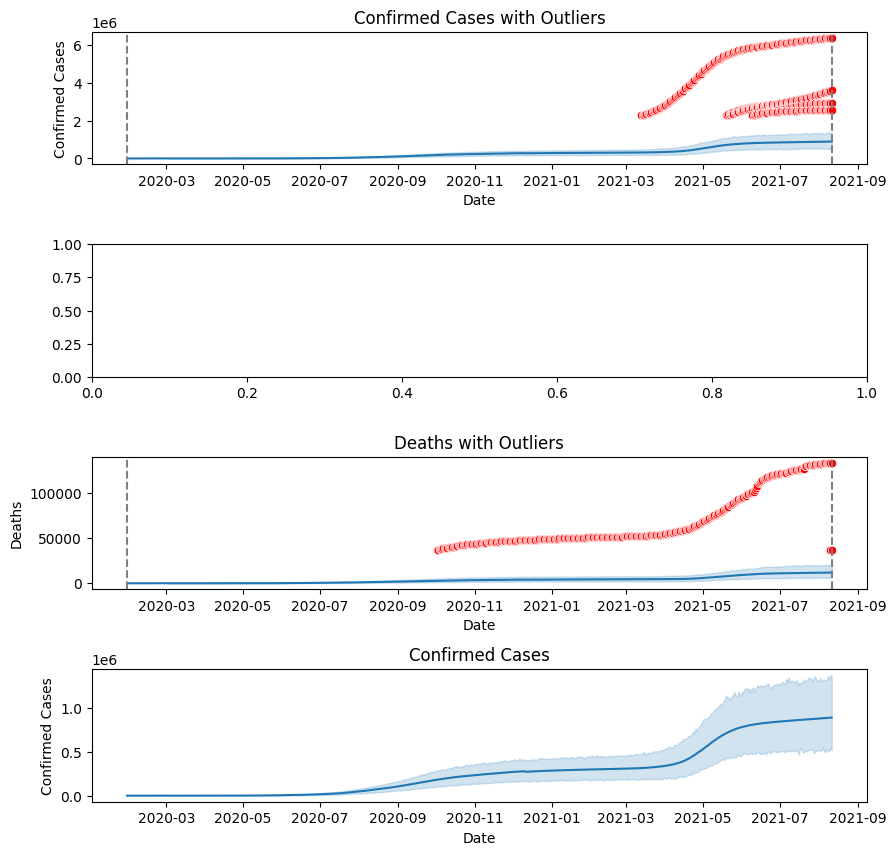

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming covid_data is already loaded into the variable 'df'
df = covid_data.copy()

# Set the date column as the index
df.set_index('Date', inplace=True)

# Specify the time period of interest
start_date = '2020-01-30'  # Start date
end_date = '2021-08-11'  # End date

# Create a new dataframe containing data for the specified time period
df_period = df.loc[start_date:end_date]

# Calculate the z-score of the Confirmed and Deaths columns
df_period['Confirmed_zscore'] = (df_period['Confirmed'] - df_period['Confirmed'].mean()) / df_period['Confirmed'].std()
df_period['Deaths_zscore'] = (df_period['Deaths'] - df_period['Deaths'].mean()) / df_period['Deaths'].std()

# Identify outliers using a z-score threshold of 3
outliers_confirmed = df_period[df_period['Confirmed_zscore'].abs() > 3]
outliers_deaths = df_period[df_period['Deaths_zscore'].abs() > 3]

# Print the outliers
print(f"Outliers in Confirmed cases:\n{outliers_confirmed}")
print(f"Outliers in Deaths:\n{outliers_deaths}")

# Plot the distribution of the Confirmed and Deaths columns
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.4})
sns.histplot(df_period['Confirmed'], ax=axs[0], bins=50)
axs[0].set_title('Distribution of Confirmed Cases')
axs[0].set_xlabel('Number of Confirmed Cases')
axs[0].set_ylabel('Frequency')

sns.histplot(df_period['Deaths'], ax=axs[1], bins=50)
axs[1].set_title('Distribution of Deaths')
axs[1].set_xlabel('Number of Deaths')
axs[1].set_ylabel('Frequency')

# Plot the time series and highlight outliers for Confirmed and Deaths columns
fig, axs = plt.subplots(4, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.6})

# Plot Confirmed cases with outliers
sns.lineplot(data=df_period, x=df_period.index, y='Confirmed', ax=axs[0])
axs[0].set_title('Confirmed Cases with Outliers')
sns.scatterplot(data=outliers_confirmed, x=outliers_confirmed.index, y='Confirmed', color='red', ax=axs[0])
axs[0].axvline(pd.to_datetime(start_date), linestyle='--', color='grey')
axs[0].axvline(pd.to_datetime(end_date), linestyle='--', color='grey')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Confirmed Cases')

# Plot Deaths with outliers
sns.lineplot(data=df_period, x=df_period.index, y='Deaths', ax=axs[2])
axs[2].set_title('Deaths with Outliers')
sns.scatterplot(data=outliers_deaths, x=outliers_deaths.index, y='Deaths', color='red', ax=axs[2])
axs[2].axvline(pd.to_datetime(start_date), linestyle='--', color='grey')
axs[2].axvline(pd.to_datetime(end_date), linestyle='--', color='grey')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Deaths')

# Plot the Confirmed time series
sns.lineplot(data=df_period, x=df_period.index, y='Confirmed', ax=axs[3])
axs[3].set_title('Confirmed Cases')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Confirmed Cases')

# Show the plots
plt.show()
